<a href="https://colab.research.google.com/github/aneesh98/CropYieldPrediction/blob/master/Copy_of_Copy_of_BEProjectDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
  A class to extract and load the Final.xlsx along with climate or soil data.
  The current code only works with soil
  Class information:
      1) Mapper : It may happen that some values having same meaning might mismatch in two dataframes. 
                  For Eg. Ahmadnagar is written as "A.Nagar" in final.xlsx and "Ahmadnagar" is soil
                  Mapper is dictionary, whose keys are the column names in final.xslx and value is the one in Soil.

      2) set_dataframe(dataframe, name): A function used to set the current dataframe csv which consists of our variable to be predicted.
                                         For eg: If I want to load Jowar.csv file, create a dataframe object of it by using pd.read_csv(...)
                                                 and pass the object in the dataframe parameter, also pass the name of the Crop you are loading
                                                 say Jowar as name argument.
      3) extract_values(dataframe): A function you don't need to care about.
      4) create_dataset(): This is the function you will be directly using, it performs NATURAL JOIN on two datasets, in our case one will be csv with crop data,
      and other with either Soil or Climate (nothing has been written for climate)
      5) append_column(): By using the above create_dataset() function if you create the dataset for one crop say Rice, and now to this same dataset you
                          want to join the values of Jowar, then you can do so by using append_column function
                    
'''
from sklearn.impute import SimpleImputer
class Extract_and_Load:
  def __init__(self, mapper = None):
    
    self.mapper = mapper
    if mapper is not None:
      self.stale_names = mapper.keys()
    
  def set_dataframe(self, dataframe, name):
    self.df = dataframe
    self.total_rows = self.df.shape[0]
    self.name = name

  def set_years(self, years):
    self.years = years

  def extract_values(self, dataframe):
    cyear = []
    District = []
    Block_name = []
    Yield = []
    for year in self.years:
      for row in range(1, self.total_rows):
        if self.df.iloc[row,0][0] == "R":
          curr_district = self.df.iloc[row,1]
          if curr_district in self.stale_names:
            curr_district = self.mapper[curr_district]
          continue
        else:
          cyear.append(int(year[0]))
          District.append(curr_district)
          if self.df.iloc[row, 1] in self.stale_names:
              Block_name.append(self.mapper[self.df.iloc[row, 1]])
          else:
              Block_name.append(self.df.iloc[row, 1])
          Yield.append(float(self.df.iloc[row, year[1]]))
    return cyear, District, Block_name, Yield
  
  def restructure_dataframe(self):
    cyear, District, Block_name, Yield = self.extract_values(self.df)
    self.col_name = self.name + '_Yield'
    new_df = {'District':District, 'Block_name':Block_name, 'Year':cyear, self.col_name:Yield}
    new_df[self.col_name] = [float(j) for j in new_df[self.col_name]]
    self.df_restructured = pd.DataFrame(new_df) 
  
  def create_dataset(self, merge_with, restructure_needed = True):
    self.merge_with = merge_with
    if restructure_needed:
      self.restructure_dataframe()
    x = merge_with.groupby(['DISTRICT','BLOCK_NAME','YEAR_OBS']).aggregate({'BLOCK_NAME':'max','DISTRICT':'max','YEAR_OBS':'max','RAINFALL':np.mean, 'GRDWTR':np.mean, 'Indexing':np.mean,'Soil_Score':'max','SOIL_TYPE':'max','Elevation':'max'})
    x = x[x['YEAR_OBS']>=2000]
    x = x.rename(columns = {"YEAR_OBS": "Year", "BLOCK_NAME":"Block_name", "DISTRICT":"District"})
    self.merged = pd.merge(x, self.df_restructured, on = ["Year", "Block_name", "District"])
    return self.merged

  def create_climate_dataset(self, merge_with, restructure_needed = True):
    self.merge_with = merge_with
    if restructure_needed:
      self.restructure_dataframe()
    imp = SimpleImputer(fill_value = 0)
    self.df_restructured_copy = self.df_restructured.copy()
    self.df_restructured_copy['Rice_Yield'] = imp.fit_transform(np.array(self.df_restructured_copy['Rice_Yield']).reshape(-1,1))
    self.df_restructured_copy['District'] = self.df_restructured_copy['District'].str.lower()
    self.merge_with['station'] = self.merge_with['station'].str.lower()
    self.merge_with = self.merge_with.rename(columns = {"station":"District", "year":"Year"})
    self.df_restructured_copy.drop(columns = ["Block_name"], inplace = True)
    self.df_restructured_copy = self.df_restructured_copy.groupby(["District", "Year"], as_index = False).aggregate({ self.col_name:np.mean})
    self.merged = pd.merge(self.merge_with, self.df_restructured_copy, on = ["Year", "District"])
    return self.merged


  def append_column(self):
    self.restructure_dataframe()
    self.merged = pd.merge(self.merged, self.df_restructured, on = ["Year", "Block_name", "District"])
    return self.merged

  def unmatched_columns(self):
    pass

In [10]:
# /content/Climate - climate_final.csv
import numpy as np
import pandas as pd
climate = pd.read_csv('Climate - climate_final.csv',delimiter=',')
uc=climate.groupby(['station', 'year']).aggregate({"rainfall":np.mean, "relative_humidity":np.mean, "average_temperature":np.mean})
# uc=climate.groupby(['station', 'year']).mean()
print(uc)
uc.to_csv(r'update_climate.csv')
updated_climate = pd.read_csv('update_climate.csv')
print(updated_climate.isnull().any())

                 rainfall  relative_humidity  average_temperature
station    year                                                  
AHMADNAGAR 2000   185.600          51.610563            24.997402
           2001   175.600          54.830765            25.286941
           2002   148.700          50.800058            25.760659
           2003   135.400          52.977195            25.745404
           2004   209.500          56.550368            25.423666
...                   ...                ...                  ...
YAVATMAL   2014   196.600          54.791829            26.785184
           2015   242.975          54.609441            27.208883
           2016   294.625          54.214109            27.437564
           2017   195.400          50.718449            27.369968
           2018   250.925          53.252706            27.131308

[665 rows x 3 columns]
station                False
year                   False
rainfall               False
relative_humidity      False
av

In [0]:
!pip install statsmodels


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
df_rice = pd.read_csv('Rice.csv')
df_soil = pd.read_csv('Soil.csv')
c1 = df_rice.columns.values[0]
column_names = ['District', 'Block_name', 'Year', 'Yield']

# total_rows = df_rice.shape[0]
mapper = {}
# Creating a Mapper Dictionary to incorporate the value mismatch as explained above
mapper['A.Nagar'] = "Ahmadnagar"
years = []
eal = Extract_and_Load(mapper)
eal.set_dataframe(df_rice, "Rice")
k = 2
# You don't need to pay attention to this for loop. 
for i in range(2000, 2017):
  years.append([i, k])
  k += 1
# cyear = []
# District = []
# Block_name = []
# Yield = []
# df_rice.iloc[1:,0]
# curr_district = ""

In [0]:
########### IMPORTANT: ONLY MOVE FORWARD AFTER YOU EXECUTE THIS CELL ###########
df_soil = df_soil.replace('#DIV/0!', 0) # Replace missing values 
df_soil['GRDWTR'] = df_soil['GRDWTR'].astype('float64') #Typecast to float
df_soil['Indexing'] = df_soil['Indexing'].astype('float64')

In [0]:
eal.set_years(years) 
eal.set_dataframe(df_rice, "Rice")
merged = eal.create_climate_dataset(updated_climate, True)

In [193]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
numeric_cols = ["rainfall", "relative_humidity", "average_temperature"]
sc = StandardScaler()
merged[numeric_cols] = sc.fit_transform(merged[numeric_cols])
model = Sequential()
model.add(layers.SimpleRNN(36, activation = "relu", input_shape = (1, 3)))
# model.add(layers.Dense(2, activation = 'relu'))
model.add(layers.Dense(1))
x_ = merged.loc[merged["District"]=="ahmadnagar", ["Year","rainfall", "relative_humidity", "average_temperature", "Rice_Yield"]]

x = x_.copy()

y = x.loc[merged["District"]=="ahmadnagar", "Rice_Yield"]
y = [np.log(i) for i in y]
x.drop(columns = ["Year","Rice_Yield"], inplace = True)
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
x_arr = np.array(x)
x_arr = x_arr.reshape((17, 1, 3))
print(x_arr.shape)
model.fit(x_arr, np.array(y), epochs = 800, validation_split = 0.1)

(17, 1, 3)
Train on 15 samples, validate on 2 samples
Epoch 1/800
15/15 [==============================] - 3s 195ms/step - loss: 3.5466 - val_loss: 3.7098
Epoch 2/800
15/15 [==============================] - 0s 830us/step - loss: 3.4935 - val_loss: 3.6577
Epoch 3/800
15/15 [==============================] - 0s 541us/step - loss: 3.4417 - val_loss: 3.6066
Epoch 4/800
15/15 [==============================] - 0s 465us/step - loss: 3.3910 - val_loss: 3.5565
Epoch 5/800
15/15 [==============================] - 0s 978us/step - loss: 3.3416 - val_loss: 3.5074
Epoch 6/800
15/15 [==============================] - 0s 968us/step - loss: 3.2933 - val_loss: 3.4593
Epoch 7/800
15/15 [==============================] - 0s 471us/step - loss: 3.2460 - val_loss: 3.4122
Epoch 8/800
15/15 [==============================] - 0s 622us/step - loss: 3.1999 - val_loss: 3.3660
Epoch 9/800
15/15 [==============================] - 0s 516us/step - loss: 3.1547 - val_loss: 3.3208
Epoch 10/800
15/15 [=================

(17, 3)


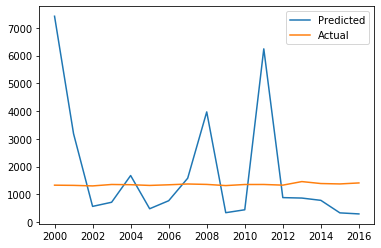

In [194]:
test_data = x_

vals = y
yr = test_data.loc[:, "Year"]
test_data.drop(columns = ["Year","Rice_Yield"], inplace = True)
test_data = np.array(test_data)

print(test_data.shape)
test_data = test_data.reshape((test_data.shape[0], 1, 3))
vals = [np.exp(i) for i in vals]
preds = model.predict(test_data)
preds = [np.exp(i) for i in preds]
import matplotlib.pyplot as plt
plt.plot(yr, preds, label = 'Predicted')
plt.plot(yr, vals, label = 'Actual')
plt.legend()

(5, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


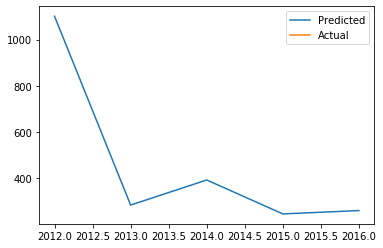

In [184]:
test_data = x_.loc[x_["Year"]>=2012, :]

vals = test_data["Rice_Yield"]
yr = x_.loc[x_["Year"] >= 2012, "Year"]
test_data.drop(columns = ["Year","Rice_Yield"], inplace = True)
test_data = np.array(test_data)

print(test_data.shape)
test_data = test_data.reshape((test_data.shape[0], 1, 3))
vals = [np.exp(i) for i in vals]
preds = model.predict(test_data)
preds = [np.exp(i) for i in preds]
import matplotlib.pyplot as plt
plt.plot(yr, preds, label = 'Predicted')
plt.plot(yr, vals, label = 'Actual')
plt.legend()

In [0]:
eal.set_years(years) #This function once called here need not be called again. 
merged = eal.create_dataset(df_soil, True) # Here is the point where the Soil and Rice data is combined into a dataset (Rice is loaded in df_rice object and Soil in df_soil)

In [0]:
# Now as we have already created the dataset to combine the Soil and Crop data (We used rice in the above example), we can now join any other crop data to this created dataset
'''
The process to do is:
    1) Call the set_dataframe function and pass in the dataframe object of the csv file for the crop (Say Jowar), which you want to combine with the dataset (It's just done using pd.read_csv) also pass the crop Name
    2) Call the append column function
'''
eal.set_dataframe(pd.read_csv("Jowar.csv"), "Jowar") 
merged_new = eal.append_column()

In [0]:
'''
After you create a new dataset or append a new column run this cell to find out if the operation was successful by checking the column names.
'''
print(merged_new.columns.values)

['Block_name' 'District' 'Year' 'RAINFALL' 'GRDWTR' 'Indexing'
 'Soil_Score' 'SOIL_TYPE' 'Elevation' 'Rice_Yield' 'Jowar_Yield']


In [0]:
print(merged_new.head())  ## Head function in pandas is used to look at first 5 tuples of the dataset.

  Block_name    District  Year  ...  Elevation  Rice_Yield  Jowar_Yield
0      Akola  Ahmadnagar  2000  ...        649       599.0          NaN
1      Akola  Ahmadnagar  2001  ...        649       500.0          NaN
2      Akola  Ahmadnagar  2002  ...        649       224.3          NaN
3      Akola  Ahmadnagar  2003  ...        649       947.1          NaN
4      Akola  Ahmadnagar  2004  ...        649       836.0          NaN

[5 rows x 11 columns]


In [0]:
merged_new.columns.values

array(['Block_name', 'District', 'Year', 'RAINFALL', 'GRDWTR', 'Indexing',
       'Soil_Score', 'SOIL_TYPE', 'Elevation', 'Rice_Yield',
       'Jowar_Yield'], dtype=object)

In [0]:
merged_copy = merged.copy()
# merged_copy.drop(columns = ['Year'])

In [0]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(fill_value = 0)
merged_copy['Rice_Yield'] = imp.fit_transform(np.array(merged_copy['Rice_Yield']).reshape(-1,1))

In [0]:
merged_copy['Jowar_Yield'] = imp.fit_transform(np.array(merged_copy['Jowar_Yield']).reshape(-1,1))

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose
t_data = merged_copy.loc[merged_copy['District'] == 'ahmadnagar', 'Year']
np.array(t_data)

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016])

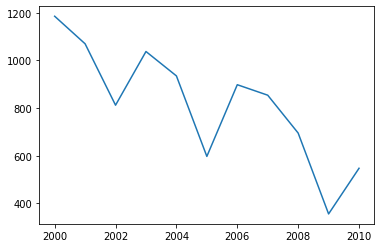

In [0]:
import matplotlib.pyplot as plt
plt.plot(merged_new.loc[merged_new['Block_name'] == 'Yavatmal', 'Year'], merged_new.loc[merged_new['Block_name'] == 'Yavatmal', 'Jowar_Yield'])

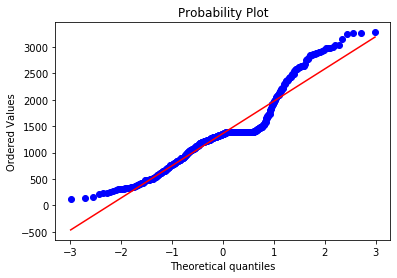

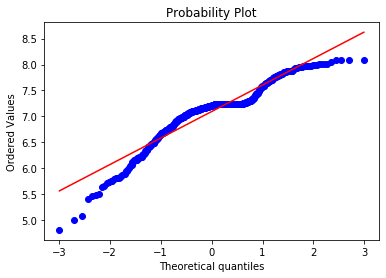

In [123]:
import scipy.stats as stats
y = merged_copy['Rice_Yield']
measurements = y
stats.probplot(measurements, dist="norm", plot=plt)
plt.figure()
measurements = [np.log(1+ i) for i in y]
stats.probplot(measurements, dist="norm", plot=plt)
merged_copy['Rice_Yield'] = measurements

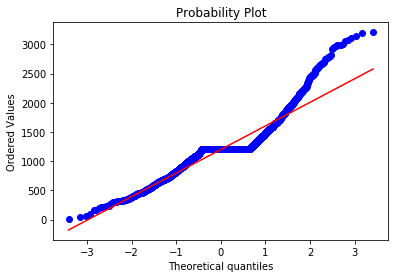

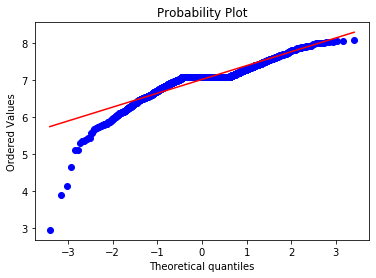

In [0]:
import scipy.stats as stats
y = merged_copy['Jowar_Yield']
measurements = y
stats.probplot(measurements, dist="norm", plot=plt)
plt.figure()
measurements = [np.log(1+ i) for i in y]
stats.probplot(measurements, dist="norm", plot=plt)
merged_copy['Jowar_Yield'] = measurements

In [0]:
merged_copy.iloc[:,:-2].columns.values

array(['Block_name', 'District', 'Year', 'RAINFALL', 'GRDWTR', 'Indexing',
       'Soil_Score', 'SOIL_TYPE', 'Elevation'], dtype=object)

In [124]:
merged_copy.head()

,District,Year,rainfall,relative_humidity,average_temperature,Rice_Yield
0,ahmadnagar,2000,-0.639577,-0.938503,-2.033424,7.192153
1,ahmadnagar,2001,-0.692463,-0.438027,-1.616349,7.186818
2,ahmadnagar,2002,-0.834724,-1.064470,-0.933968,7.171808
3,ahmadnagar,2003,-0.905061,-0.726105,-0.955943,7.210690
4,ahmadnagar,2004,-0.513182,-0.170771,-1.419399,7.204811


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# mm = MinMaxScaler()
le = LabelEncoder()

# merged_copy['SOIL_TYPE'] = le.fit_transform(merged_copy['SOIL_TYPE'])
# merged_copy["Block_name"] = le.fit_transform(merged_copy['Block_name'])
# merged_copy["District"] = le.fit_transform(merged_copy['District'])
merged_copy["District"] = le.fit_transform(merged_copy["District"])
# yrs = merged_copy.loc[merged_copy["District"] == "ahmadnagar", "Year"]

# merged_copy = mm.fit_transform(merged_copy)
# merged[[k for k in columns if k != 'SOIL_TYPE']] = mm.fit(merged[[k for k in columns if k != 'SOIL_TYPE']])
X_train, X_test, y_train, y_test = train_test_split(merged_copy.iloc[:,:-1], merged_copy['Rice_Yield'], test_size = 0.2)


In [0]:
X_train.drop(columns = ["Year"], inplace= True)
X_test = X_test.sort_values(["Year"], ascending = [True])
yrs = X_test.loc[X_test["District"] == 14, "Year"]
X_test.drop(columns = ["Year"], inplace = True)


In [178]:
print(yrs)

240    2002
245    2007
248    2010
Name: Year, dtype: int64


In [179]:
rf_rice = RandomForestRegressor(max_depth = 10, n_estimators = 100, random_state= False, verbose=0)
rf_rice.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=False, verbose=0, warm_start=False)

[27 20  0 16 15 21  7 21 14 20 22 18  4 17 15 24 22  6 25  5  0  2 17 12
 19 15  3 20  1 13  5 28 18  1 10 15 26 21 14  2 11  3 10  8 20  5 21  1
 27  2 23 18 25 17 27 12 22 19 14  3 11 10 11  1 12  3 20  4 20  2  7 23
 16 22 19 11  9  4 16 18  6 20 13 25 21  7 20  5  3  0  1 26 21 12  3 19
 17  4 16]


ValueError: ignored

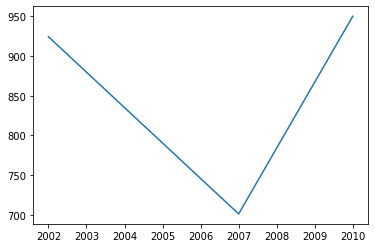

In [183]:
print(le.inverse_transform(X_test["District"]))
vals = rf_rice.predict(X_test.loc[X_test["District"] == 14, :])

plt.plot(yrs, vals)
plt.plot(yrs, y_test)

In [0]:
X_train.columns.values

array(['Block_name', 'District', 'Year', 'RAINFALL', 'GRDWTR', 'Indexing',
       'Soil_Score', 'SOIL_TYPE', 'Elevation'], dtype=object)

In [181]:
from xgboost.sklearn import XGBRegressor
xgrb_rice = XGBRegressor(obj = 'reg:squarederror', n_estimators = 500)
xgrb_rice.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, obj='reg:squarederror',
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [0]:
merged_copy_jowar = merged_copy.drop(columns=['Rice_Yield'])
print(merged_copy_jowar.columns.values)
X_train, X_test, y_train, y_test =train_test_split(merged_copy_jowar.iloc[:,:-1], merged_copy_jowar['Jowar_Yield'], test_size = 0.2)



['Block_name' 'District' 'Year' 'RAINFALL' 'GRDWTR' 'Indexing'
 'Soil_Score' 'SOIL_TYPE' 'Elevation' 'Jowar_Yield']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=False, verbose=1, warm_start=False)

In [0]:
rf_jowar = RandomForestRegressor(max_depth = 10, n_estimators = 100, random_state= False, verbose=0)
rf_jowar.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=False, verbose=0, warm_start=False)

In [0]:
print(X_test.columns.values)

['Block_name' 'District' 'Year' 'RAINFALL' 'GRDWTR' 'Indexing'
 'Soil_Score' 'SOIL_TYPE' 'Elevation']


In [0]:
val = rf_jowar.predict(np.array(X_test.iloc[1,:]).reshape(1,-1))[0]
print(np.exp(val) - 1)
for vals in range(1, X_test.shape[0]):
  val1 = rf_jowar.predict(np.array(X_test.iloc[vals,:]).reshape(1,-1))[0]
  val2 = rf_rice.predict(np.array(X_test.iloc[vals,:]).reshape(1,-1))[0]
  if val1 > val2:
    print("Cultivate Jowar, You can get yield of ", np.exp(val1) - 1)
  else:
    print("Cultivate Rice, You can get yield of ", np.exp(val2) - 1)

1170.6403112730613
Cultivate Rice, You can get yield of  1170.6403112730613
Cultivate Rice, You can get yield of  857.759084014366
Cultivate Rice, You can get yield of  1199.8549533769296
Cultivate Rice, You can get yield of  1191.5787860602175
Cultivate Rice, You can get yield of  1773.3095352015132
Cultivate Rice, You can get yield of  943.0392907689574
Cultivate Rice, You can get yield of  1388.058270241465
Cultivate Rice, You can get yield of  1200.3998970002335
Cultivate Rice, You can get yield of  1211.655398518519
Cultivate Rice, You can get yield of  1199.8410923285467
Cultivate Rice, You can get yield of  895.1973414326766
Cultivate Rice, You can get yield of  931.1686046435946
Cultivate Rice, You can get yield of  1109.3706491142405
Cultivate Rice, You can get yield of  1235.1151614277996
Cultivate Rice, You can get yield of  677.7174116834053
Cultivate Rice, You can get yield of  1200.239274857595
Cultivate Rice, You can get yield of  1199.6972521738478
Cultivate Rice, You c

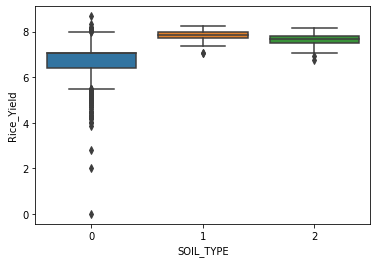

In [0]:
import seaborn as sns
sns.boxplot(x='SOIL_TYPE', y='Rice_Yield', data = merged_copy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=False, verbose=1, warm_start=False)

In [0]:
from sklearn import metrics
y_pred = rf.predict(X_test)
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

4.189321999677256e-05
0.006472497199441075


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [0]:
'''
CODE AFTER THIS CELL IS OLD CODE. It is data visualization at various levels of aggregation. Executing these cells
may cause error. 
'''

In [0]:
print(len(cyear))
def extract_csv(df):
  for year in years:
    for row in range(1, total_rows):
      if df.iloc[row,0][0] == "R":
        curr_district = df.iloc[row,1]
        continue
      else:
        cyear.append(int(year[0]))
        if curr_district == 'A.Nagar':
          curr_district = 'Ahmadnagar'
        District.append(curr_district)
        if df.iloc[row, 1] == 'A.Nagar':
            Block_name.append('Ahmadnagar')
        else:
            Block_name.append(df.iloc[row, 1])
        Yield.append(float(df.iloc[row, year[1]]))
  return cyear, District, Block_name, Yield


0


In [0]:
cyear, District, Block_name, Yield = extract_csv(df_rice)

In [0]:
new_rice = {'District':District, 'Block_name':Block_name, 'Year':cyear, 'Yield':Yield}
df_nrice = pd.DataFrame(new_rice)
df_nrice.head()
df_nrice.to_csv('Restructured_Data.csv', index=False)

In [0]:
import seaborn as sns


def getCrossTab(feature_name, label, dataframe):
  data_ct = pd.crosstab(dataframe[feature_name], dataframe[label], margins = False)
  return data_ct

def drawBoxPlot(feature, label, df_, subplots = False, nrows = 0, ncolumns = 0):
  if not subplots:
    sns.boxplot(x=label, y = feature, data = df_)
  else:
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.8, wspace = 0.8)
    d = 0
    for row in range(nrows):
      for col in range(ncolumns):
        sns.boxplot(x=label, y=feature[d], data=df_, ax = ax[row, col])
        d += 1
        if d >= len(feature):
          return

def drawHist(feature, df_, subplots = False, nrows = 0, ncolumns = 0):
  if not subplots:
    plt.hist(df_[feature])
  else:
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.8, wspace = 0.8)
    d = 0
    for row in range(nrows):
      for col in range(ncolumns):
        ax[row, col].hist(df_[feature[d]])
        ax[row, col].set_xlabel(feature[d])
        d += 1
        if d >= len(feature):
          return

In [0]:
df_nrice.loc[:,'Yield'] = df_nrice['Yield'].astype(dtype = 'float64')

In [0]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
df_nrice['Yield'] = imp.fit_transform(df_nrice['Yield'].values.reshape(-1,1))

In [0]:
df_agg = ((df_nrice.groupby(['District', 'Year'])).mean()).loc[:,['Yield']]
df_agg

Yield
District   Year       
Ahmadnagar 2000  599.0
           2001  500.0
           2002  224.3
           2003  947.1
           2004  836.0
...                ...
Yavatmal   2012    NaN
           2013    NaN
           2014    NaN
           2015    NaN
           2016    NaN

[595 rows x 1 columns]

In [0]:
(df_soil[(df_soil['DISTRICT'] == 'Ratnagiri') & (df_soil['YEAR_OBS']>=2000)]).groupby()

,x,DISTRICT,TEH_NAME,BLOCK_NAME,LAT,LON,SITE_NAME,YEAR_OBS,RAINFALL,GRDWTR,SOIL_TYPE,Soil_Score,Elevation,Indexing
840,MS,Ratnagiri,Guhagar,Dapoli,17.762500,73.191667,Dapoli,2010,4201.70,5.58,Laterite,3,14,16836.54
841,MS,Ratnagiri,Kherdi,Lanja,16.790278,73.575556,Vankhed,2010,4201.70,4.286666667,Laterite,3,12,16831.66
842,MS,Ratnagiri,Khed,Khed,17.766667,73.416667,Kalvane,2010,4201.70,3.89,Laterite,3,616,17132.47
843,MS,Ratnagiri,Guhagar,Dapoli,17.590000,73.176944,Dabhol,2010,4201.70,4.696666667,Laterite,3,14,16833.89
844,MS,Ratnagiri,Guhagar,Dapoli,17.783889,73.238611,Karanjani,2010,4201.70,5.766666667,Laterite,3,14,16837.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,MS,Ratnagiri,Nachane,Ratnagiri,16.912500,73.347222,Pomendi (Kh),2000,4619.05,3.9675,Laterite,3,129,18558.6025
13588,MS,Ratnagiri,Rajapur,Rajapur,16.650000,73.516667,Rajapur,2000,4619.05,12.005,Laterite,3,34,18535.215
13589,MS,Ratnagiri,Rajapur,Rajapur,16.655833,73.430556,Solgaon,2000,4619.05,4.8675,Laterite,3,34,18513.8025
13590,MS,Ratnagiri,Rajapur,Rajapur,16.700000,73.700000,Raipatan,2000,4619.05,3.59,Laterite,3,34,18509.97


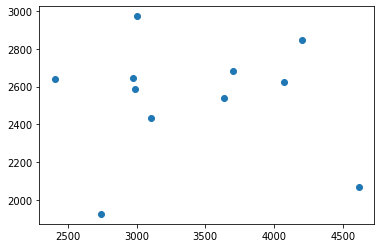

In [0]:
x = (df_soil[(df_soil['DISTRICT'] == 'Ratnagiri') & (df_soil['YEAR_OBS']>=2000)]).groupby(['YEAR_OBS']).mean().loc[:,'RAINFALL']
y = df_nrice[(df_nrice['District'] == 'Ratnagiri') & (df_nrice['Year'] <=2010)].groupby(['Year']).mean().loc[:,['Yield']]
plt.scatter(x,y)

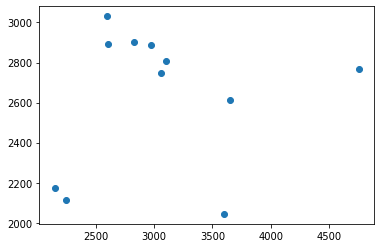

In [0]:
x = (df_soil[(df_soil['DISTRICT'] == 'Sindhudurg') & (df_soil['YEAR_OBS']>=2000)]).groupby(['YEAR_OBS']).mean().loc[:,'RAINFALL']
y = df_nrice[(df_nrice['District'] == 'Sindhudurg') & (df_nrice['Year'] <=2010)].groupby(['Year']).mean().loc[:,['Yield']]
plt.scatter(x,y)

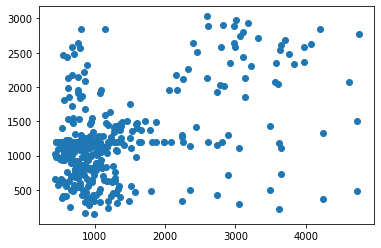

In [0]:
x = (df_soil[(df_soil['YEAR_OBS']>=2000)]).groupby(['DISTRICT','YEAR_OBS']).mean().loc[:,'RAINFALL']
y = df_nrice[(df_nrice['Year'] <=2010)].groupby(['District','Year']).mean().loc[:,['Yield']]
plt.scatter(x,y)

In [0]:
df_soil[df_soil['YEAR_OBS'] >= 2000].shape, df_nrice[df_nrice['Year'] <= 2010].shape

((13955, 14), (3938, 4))

In [0]:
df_soil['SOIL_TYPE']

0        Black
1        Black
2        Black
3        Black
4        Black
         ...  
19021    Black
19022    Black
19023    Black
19024    Black
19025    Black
Name: SOIL_TYPE, Length: 19026, dtype: object

In [0]:
(df_soil.groupby(['DISTRICT', 'YEAR_OBS']).mean()).loc[:,['RAINFALL']]

RAINFALL
DISTRICT   YEAR_OBS          
Ahmadnagar 1996       965.080
           1997       953.641
           1998       940.414
           1999       825.431
           2000       595.302
...                       ...
Yavatmal   2006      1290.000
           2007       796.100
           2008       704.500
           2009       570.000
           2010      1201.700

[525 rows x 1 columns]

In [0]:
x = df_soil.groupby(['DISTRICT','BLOCK_NAME','YEAR_OBS']).aggregate({'BLOCK_NAME':'max','DISTRICT':'max','YEAR_OBS':'max','RAINFALL':np.mean, 'GRDWTR':np.mean, 'Indexing':np.mean,'Soil_Score':'max','SOIL_TYPE':'max','Elevation':'max'})
print(x.columns.values)
# x = x.loc[(x['DISTRICT'] == 'Ratnagiri') & (x['YEAR_OBS']>=2000),:]
y = df_nrice
print(x.head(20))

['BLOCK_NAME' 'DISTRICT' 'YEAR_OBS' 'RAINFALL' 'GRDWTR' 'Indexing'
 'Soil_Score' 'SOIL_TYPE' 'Elevation']
                               BLOCK_NAME    DISTRICT  ...  SOIL_TYPE  Elevation
DISTRICT   BLOCK_NAME YEAR_OBS                         ...                      
Ahmadnagar Akola      1996          Akola  Ahmadnagar  ...      Black        649
                      1997          Akola  Ahmadnagar  ...      Black        649
                      1998          Akola  Ahmadnagar  ...      Black        649
                      1999          Akola  Ahmadnagar  ...      Black        649
                      2000          Akola  Ahmadnagar  ...      Black        649
                      2001          Akola  Ahmadnagar  ...      Black        649
                      2002          Akola  Ahmadnagar  ...      Black        649
                      2003          Akola  Ahmadnagar  ...      Black        649
                      2004          Akola  Ahmadnagar  ...      Black        649
   

In [0]:
distsoil = list(set(df_soil['DISTRICT']))
districe = list(set(df_nrice['District']))
matched = []
for k in districe:
  if k in distsoil:
    matched.append(k)
print(matched)
print(len(matched), len(districe))
unmatched = [r for r in districe if r not in matched]
print(unmatched)

['Pune', 'Nashik', 'Dhule', 'Amravati', 'Chandrapur', 'Satara', 'Latur', 'Bhandara', 'Nagpur', 'Yavatmal', 'Osmanabad', 'Wardha', 'Ahmadnagar', 'Jalna', 'Thane', 'Solapur', 'Ratnagiri', 'Aurangabad', 'Nandurbar', 'Washim', 'Akola', 'Kolhapur', 'Hingoli', 'Parbhani', 'Jalgaon', 'Nanded', 'Sindhudurg']
27 35
['Beed', 'Gadchiroli', 'Gondia', 'Sangali', 'Raigad', 'Gr.Bombay', 'Buldhana', 'Palghar']


In [0]:
df_nnrice = df_nrice[(df_nrice['District'].isin(matched)) & (df_nrice['Year'] <= 2010)]
df_nnrice.columns.values

array(['District', 'Block_name', 'Year', 'Yield'], dtype=object)

In [0]:
x = x[x['YEAR_OBS']>=2000]
x = x.rename(columns = {"YEAR_OBS": "Year", "BLOCK_NAME":"Block_name", "DISTRICT":"District"})
x.columns.values

array(['Block_name', 'District', 'Year', 'RAINFALL', 'GRDWTR', 'Indexing',
       'Soil_Score', 'SOIL_TYPE', 'Elevation'], dtype=object)

In [0]:
merged = pd.merge(x, df_nnrice, on = ["Year", "Block_name", "District"])
print(merged)

     Block_name    District  Year  ...  SOIL_TYPE  Elevation    Yield
0         Akola  Ahmadnagar  2000  ...      Black        649   599.00
1         Akola  Ahmadnagar  2001  ...      Black        649   500.00
2         Akola  Ahmadnagar  2002  ...      Black        649   224.30
3         Akola  Ahmadnagar  2003  ...      Black        649   947.10
4         Akola  Ahmadnagar  2004  ...      Black        649   836.00
...         ...         ...   ...  ...        ...        ...      ...
2142   Yavatmal    Yavatmal  2006  ...      Black        457   431.00
2143   Yavatmal    Yavatmal  2007  ...      Black        457   831.00
2144   Yavatmal    Yavatmal  2008  ...      Black        457  1203.75
2145   Yavatmal    Yavatmal  2009  ...      Black        457  1203.75
2146   Yavatmal    Yavatmal  2010  ...      Black        457  1203.75

[2147 rows x 10 columns]


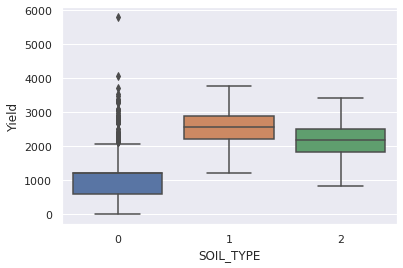

In [0]:
%matplotlib inline
drawBoxPlot('Yield', 'SOIL_TYPE', merged)

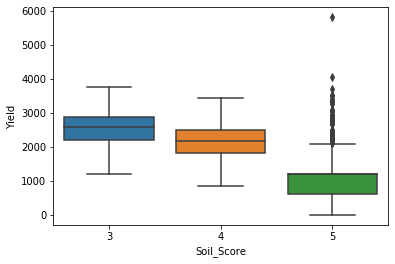

In [0]:
drawBoxPlot('Yield', 'Soil_Score', merged)

The dots in the plots above are indicative of outliers

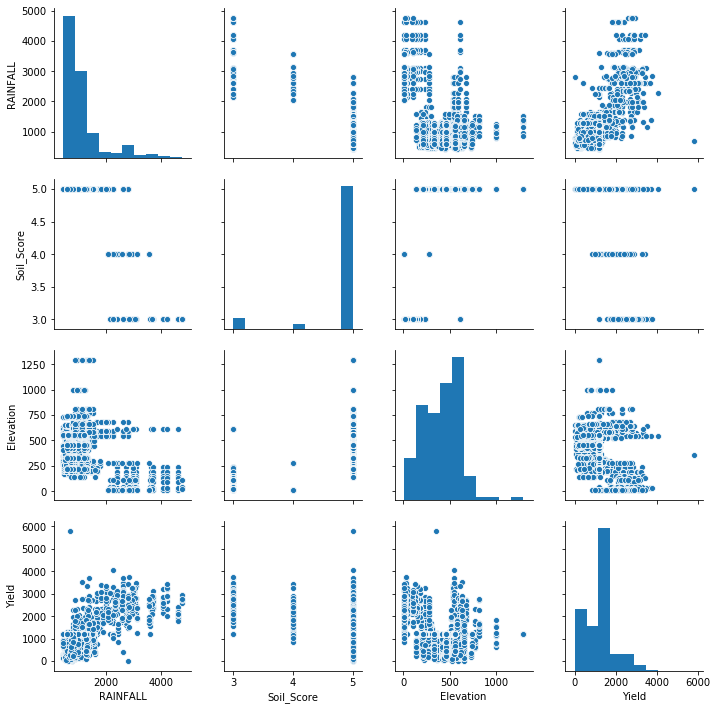

In [0]:
columns = ['RAINFALL', 'SOIL_TYPE', 'Soil_Score', 'Elevation', 'Yield']
sns.pairplot(merged[columns])

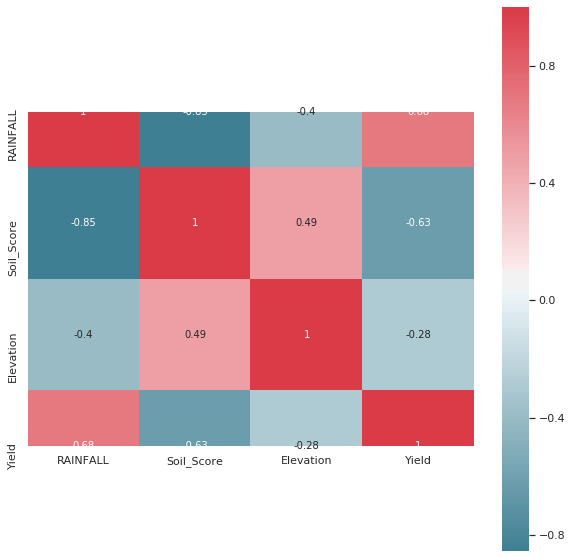

In [0]:
%matplotlib inline
sns.set(font_scale = 1)
cmap_, ax = plt.subplots(figsize = (10,10))
corr = merged[columns].corr(method = 'pearson')
# cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, cmap = cmap, square = True, 
            ax=ax, annot=True,
           annot_kws = {'fontsize': 10})